In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.metrics import accuracy_score
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
%matplotlib inline

from tqdm import tqdm
import random
import tensorflow as tf2

In [2]:
# print("Num GPUs Available: ", len(tf2.config.experimental.list_physical_devices('GPU')))
tf.test.gpu_device_name()

''

In [3]:
import csv

with open('adult.data') as input_file:
    lines = input_file.readlines()
    newLines = []
    for line in lines:
        newLine = line.strip().split()
        newLine = [value.replace(',','') for value in newLine]
        newLines.append( newLine )

In [4]:
data = pd.DataFrame(columns=['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain',
                            'capital_loss','hours_per_week','native_country','income'], data=newLines)

In [5]:
data

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [6]:
numeric_columns = ['age','fnlwgt','education_num','capital_gain','capital_loss','hours_per_week']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric)

In [7]:
data = data.dropna()

In [8]:
cat_cols = ['workclass', 'marital_status','occupation','relationship','race','sex','native_country']

def top_10(col_name):
    top_values = data[col_name].value_counts()[:9].index
    return data[col_name].apply(lambda x: x if x in top_values else 'other')

for col in cat_cols:
    data[col] = top_10(col)

<ipython-input-8-f2483fa17bb3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = top_10(col)


In [9]:
def hourbin(value):
    if value < 20:
        return 1
    elif (value >= 20) & (value < 40):
        return 2
    elif (value >= 40) & (value < 60):
        return 3
    else:
        return 4
    
data['hours_per_week'] = data['hours_per_week'].apply(hourbin)

<ipython-input-9-1c00b2503ac1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hours_per_week'] = data['hours_per_week'].apply(hourbin)


In [10]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

<ipython-input-10-1687e21937d9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)


In [11]:
data

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,3,United-States,0
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,1,United-States,0
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,other,Not-in-family,White,Male,0.0,0.0,3,United-States,0
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,other,Husband,Black,Male,0.0,0.0,3,United-States,0
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,3,other,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,other,Wife,White,Female,0.0,0.0,2,United-States,0
32557,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,3,United-States,1
32558,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,3,United-States,0
32559,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,2,United-States,0


In [12]:
data = data.drop(['fnlwgt','education'], axis=1)

for col in cat_cols:
    data = data.join(pd.get_dummies(data[col], drop_first=True, prefix=col))
    del data[col]


In [13]:
data

,age,education_num,capital_gain,capital_loss,hours_per_week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,sex_Male,native_country_Canada,native_country_El-Salvador,native_country_Germany,native_country_India,native_country_Mexico,native_country_Philippines,native_country_Puerto-Rico,native_country_United-States,native_country_other
0,39.0,13.0,2174.0,0.0,3,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,50.0,13.0,0.0,0.0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,38.0,9.0,0.0,0.0,3,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
3,53.0,7.0,0.0,0.0,3,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,28.0,13.0,0.0,0.0,3,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,12.0,0.0,0.0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
32557,40.0,9.0,0.0,0.0,3,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
32558,58.0,9.0,0.0,0.0,3,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
32559,22.0,9.0,0.0,0.0,2,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0


In [14]:
x_data = data.drop('income', axis=1)
y_data = data['income']

cont_cols = ['age','capital_gain','capital_loss']

for col in cont_cols:
    m = x_data[col].mean()
    s = np.std(x_data[col])
    x_data[col] = x_data[col].apply(lambda x: (x-m)/s)

In [15]:
pd.set_option('display.max_columns', 500)
x_data

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital_status_Married-AF-spouse,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,occupation_Adm-clerical,occupation_Craft-repair,occupation_Exec-managerial,occupation_Machine-op-inspct,occupation_Other-service,occupation_Prof-specialty,occupation_Sales,occupation_Transport-moving,occupation_other,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native_country_Canada,native_country_El-Salvador,native_country_Germany,native_country_India,native_country_Mexico,native_country_Philippines,native_country_Puerto-Rico,native_country_United-States,native_country_other
0,0.030671,13.0,0.148453,-0.21666,3,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
1,0.837109,13.0,-0.145920,-0.21666,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
2,-0.042642,9.0,-0.145920,-0.21666,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
3,1.057047,7.0,-0.145920,-0.21666,3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
4,-0.775768,13.0,-0.145920,-0.21666,3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.849080,12.0,-0.145920,-0.21666,2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
32557,0.103983,9.0,-0.145920,-0.21666,3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
32558,1.423610,9.0,-0.145920,-0.21666,3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
32559,-1.215643,9.0,-0.145920,-0.21666,2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0


In [25]:
d1 = data.groupby('income').mean()
d1

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital_status_Married-AF-spouse,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,occupation_Adm-clerical,occupation_Craft-repair,occupation_Exec-managerial,occupation_Machine-op-inspct,occupation_Other-service,occupation_Prof-specialty,occupation_Sales,occupation_Transport-moving,occupation_other,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native_country_Canada,native_country_El-Salvador,native_country_Germany,native_country_India,native_country_Mexico,native_country_Philippines,native_country_Puerto-Rico,native_country_United-States,native_country_other
income,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,36.783738,9.595065,148.752468,53.142921,2.713633,0.023827,0.059709,0.000283,0.717354,0.019984,0.073503,0.038228,0.000566,0.000526,0.335113,0.015534,0.412298,0.038794,0.036731,0.131998,0.128236,0.084871,0.070874,0.127751,0.092273,0.107888,0.051659,0.137621,0.301335,0.038188,0.202306,0.130583,0.033293,0.030866,0.110720,0.009951,0.837338,0.611974,0.003317,0.003924,0.003762,0.002427,0.024676,0.005542,0.004126,0.889927,0.044620
1,44.249841,11.611657,4006.142456,195.001530,3.025124,0.047315,0.078689,0.000000,0.632955,0.079327,0.092335,0.045020,0.000000,0.001275,0.853463,0.004336,0.062620,0.008417,0.010840,0.064660,0.118480,0.250988,0.031884,0.017472,0.237087,0.125367,0.040811,0.088892,0.109170,0.004719,0.008545,0.027803,0.095013,0.035200,0.049356,0.003188,0.907665,0.849637,0.004974,0.001148,0.005612,0.005101,0.004209,0.007780,0.001530,0.914552,0.036475


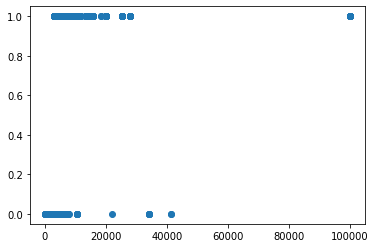

In [26]:
plt.scatter(data[data['capital_gain']>0]['capital_gain'], data[data['capital_gain']>0]['income'])

In [44]:
x_nu = ['age','capital_gain','education_num','capital_loss','hours_per_week']
fs = SelectKBest(score_func=chi2, k=15)
fs.fit_transform(x_data.drop(x_nu, axis=1), y_data)

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 1],
       [1, 1, 0, ..., 1, 0, 0]], dtype=uint8)

In [45]:
fs.get_support(indices=True)

array([ 4,  9, 11, 12, 14, 16, 18, 19, 23, 24, 25, 26, 27, 29, 32])

In [48]:
score_df = pd.DataFrame({'columns':x_data.drop(x_nu, axis=1).columns, 'score':fs.scores_}).sort_values('score', ascending=False).reset_index(drop=True)
list(score_df.loc[:15,'columns']) + x_nu

['marital_status_Married-civ-spouse',
 'marital_status_Never-married',
 'relationship_Own-child',
 'occupation_Exec-managerial',
 'occupation_Prof-specialty',
 'relationship_Not-in-family',
 'occupation_Other-service',
 'workclass_Self-emp-inc',
 'relationship_Unmarried',
 'sex_Male',
 'relationship_Wife',
 'race_Black',
 'occupation_Adm-clerical',
 'relationship_Other-relative',
 'marital_status_Separated',
 'occupation_Machine-op-inspct',
 'age',
 'capital_gain',
 'education_num',
 'capital_loss',
 'hours_per_week']

In [49]:
x_data = x_data[list(score_df.loc[:15,'columns']) + x_nu]

In [16]:
n_features = 47
n_dense_neurons_1 = 47

x = tf.placeholder(float, (None, n_features))
y = tf.placeholder(dtype=float)

W1 = tf.Variable(tf.random_normal([n_features, n_dense_neurons_1]))
b1 = tf.Variable(tf.zeros(n_dense_neurons_1))

z1 = tf.add(tf.matmul(x, W1), b1)
a1 = tf.sigmoid(z1)

drop_out_1 = tf.nn.dropout(a1, 0.5)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
n_dense_neurons_2 = 20

W2 = tf.Variable(tf.random_normal([n_dense_neurons_1, n_dense_neurons_2]))
b2 = tf.Variable(tf.zeros(n_dense_neurons_2))

z2 = tf.add(tf.matmul(drop_out_1, W2), b2)
a2 = tf.sigmoid(z2)

drop_out_2 = tf.nn.dropout(a2, 0.5)

In [18]:
n_dense_neurons_3 = 1

W3 = tf.Variable(tf.random_normal([n_dense_neurons_2, n_dense_neurons_3]))
b3 = tf.Variable(tf.zeros(n_dense_neurons_3))

z3 = tf.add(tf.matmul(drop_out_2, W3), b3)
a3 = tf.sigmoid(z3)

In [19]:
loss = tf.reduce_sum(-(y*tf.math.log(a3) + (1-y)*tf.math.log(1-a3)))

In [20]:
sess = tf.Session()
init = tf.global_variables_initializer()  
sess.run(init)

In [21]:
optimizer = tf.train.GradientDescentOptimizer(0.00001)
train = optimizer.minimize(loss)

In [1]:
training_epochs = 200
batch_size = 32
train_size = x_data.shape[0]

for epoch in tqdm(range(training_epochs)):
    X = x_data.copy()
    Y = y_data.copy()
    for batch in range(int(train_size/batch_size)+1):
        
        if X.shape[0] > batch_size:
            random_index = random.sample(list(range(X.shape[0])), batch_size)

            x_sample = np.array(X.loc[random_index, :])
            y_sample = np.array(Y.loc[random_index])

            X = X[~X.index.isin(random_index)].reset_index(drop=True)
            Y = Y[~Y.index.isin(random_index)].reset_index(drop=True)
        else:
            x_sample = np.array(X)
            y_sample = np.array(Y)
            
        sess.run(train, feed_dict = {x:x_sample, y:y_sample})
        
    if (epoch+1)%10 == 0:
        c_train = sess.run(loss, feed_dict = {x:np.array(x_data), y:np.array(y_data)})
        training_pred = sess.run(a3, feed_dict = {x : x_train, y : y_train})
        training_threshold = np.median(training_pred)
        training_pred = [1 if i>training_threshold else 0 for i in training_pred]
        training_accuracy = accuracy_score(y_data, training_pred)
        
        print("Epoch", (epoch + 1), ": Train loss =", c_train/x_data.shape[0], "Training accuracy =", training_accuracy) 


NameError: name 'x_data' is not defined

In [184]:
import random
ind = random.sample(list(range(x_data.shape[0])), 10)
np.array(y_data.loc[ind])
# y_data[~y_data.index.isin([0,1,2,3,4])]

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 0])

In [186]:
X = x_data.copy()
X = X[~X.index.isin([0,1,2,3,4])].reset_index(drop=True)
X

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital_status_Married-AF-spouse,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,occupation_Adm-clerical,occupation_Craft-repair,occupation_Exec-managerial,occupation_Machine-op-inspct,occupation_Other-service,occupation_Prof-specialty,occupation_Sales,occupation_Transport-moving,occupation_other,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native_country_Canada,native_country_El-Salvador,native_country_Germany,native_country_India,native_country_Mexico,native_country_Philippines,native_country_Puerto-Rico,native_country_United-States,native_country_other
0,-0.115955,14.0,-0.145920,-0.21666,3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,0.763796,5.0,-0.145920,-0.21666,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,0.983734,9.0,-0.145920,-0.21666,3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
3,-0.555830,14.0,1.761142,-0.21666,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,0.250608,13.0,0.555214,-0.21666,3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32551,-0.849080,12.0,-0.145920,-0.21666,2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
32552,0.103983,9.0,-0.145920,-0.21666,3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
32553,1.423610,9.0,-0.145920,-0.21666,3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
32554,-1.215643,9.0,-0.145920,-0.21666,2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0


In [192]:
y_data.shape

(32561,)